In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from os import path
import matplotlib.ticker as ticker
from scipy import stats
from sklearn.linear_model import LinearRegression

labels = ["paiceHusk", "krovetz", "sStripping", "porter2", "lovins", "wikt", "none"]
maxLengths = [20, 55, 148, 403, 1097, 2981, 2000000]
collection_n_values = [64, 32, 16, 8, 4, 2, 1]
collection_sizes = [817857, 1635715, 3271430, 6542860, 13085721, 26171443, 52342886]

data_dir_clueweb = path.join("Data", "clueweb")
data_dir_wikt = path.join("Data", "wikt")

MARKERS = ["o","^","s","*","d", "P", "X"]
markers = itertools.cycle(MARKERS)

## nDCG

In [2]:
#Initialise data dictionary with column names and empty lists
data = {"maxLength" : [], "n" : [], "collectionSize" : [], "stemmer" : [], "QID" : [], "nDCG" : []}
data_avg = {"maxLength" : [], "n" : [], "collectionSize" : [], "stemmer" : [], "nDCG" : []}
QID = np.arange(201,301)
for length, n, size in zip(maxLengths, collection_n_values, collection_sizes):
    #Gather the data from each length file
    values = list()
    values_avg = list()
    queryTotal = 0
    with open(path.join(data_dir_clueweb,f"combined/nDCG-{length}-{n}"), "r") as f:
        for line in f:
            if line[0].isalpha(): 
                queryTotal = 0
                continue
            queryTotal+=1
            if queryTotal > 100:
                values_avg.append(float(line.strip()))
                continue
            values.append(float(line.strip()))
    i = 0
    for stemmer in labels:
        data["nDCG"].extend(values[100*i:100*(i+1)])
        data["maxLength"].extend([length for _ in QID])
        data["n"].extend([n for _ in QID])
        data["collectionSize"].extend([size for _ in QID])
        data["stemmer"].extend([stemmer for _ in QID])
        data["QID"].extend(QID)
        i+=1
    data_avg["nDCG"].extend(values_avg)
    data_avg["maxLength"].extend([length for _ in labels])
    data_avg["stemmer"].extend(labels)
    data_avg["n"].extend([n for _ in labels])
    data_avg["collectionSize"].extend([size for _ in labels])
nDCG = pd.DataFrame(data)
nDCG_avg = pd.DataFrame(data_avg)
display(nDCG)
# display(nDCG_avg)

,maxLength,n,collectionSize,stemmer,QID,nDCG
0,20,64,817857,paiceHusk,201,0.000000
1,20,64,817857,paiceHusk,202,0.000000
2,20,64,817857,paiceHusk,203,0.000000
3,20,64,817857,paiceHusk,204,0.000000
4,20,64,817857,paiceHusk,205,0.000000
...,...,...,...,...,...,...
4895,2000000,1,52342886,none,296,0.819635
4896,2000000,1,52342886,none,297,0.743544
4897,2000000,1,52342886,none,298,0.000000
4898,2000000,1,52342886,none,299,0.443925


In [3]:
target_data = nDCG_avg

best_nDCG = list()
for length in np.unique(target_data["maxLength"]):
    selected_data = nDCG_avg[nDCG_avg["maxLength"] == length]
    best_nDCG.append(selected_data["nDCG"].max())

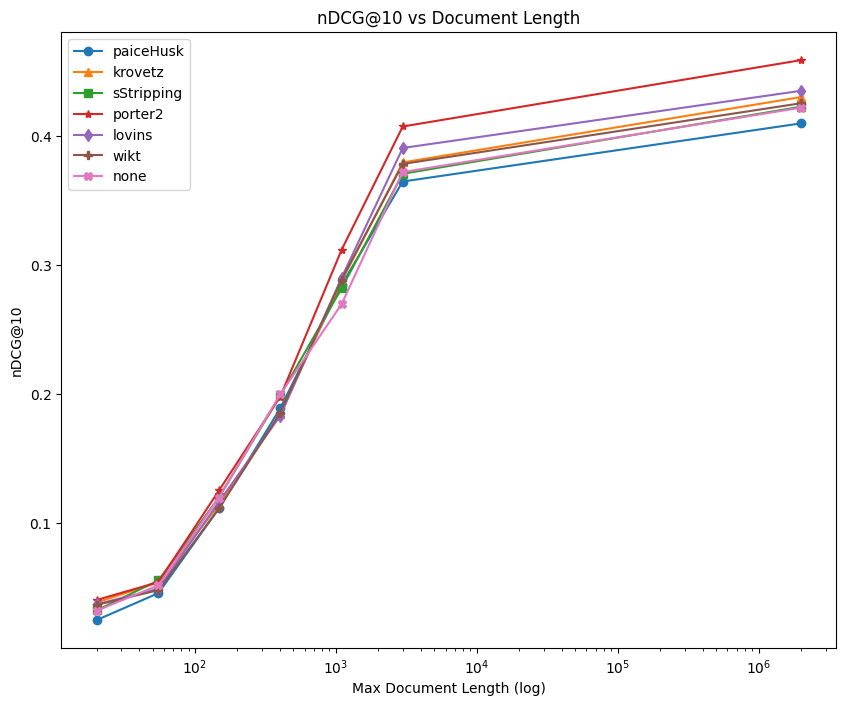

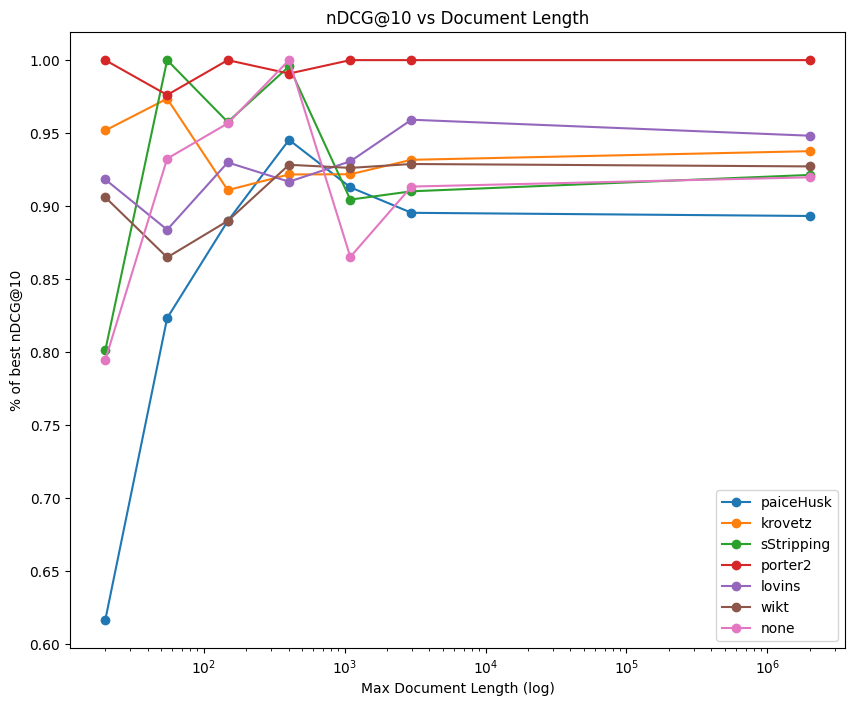

In [43]:
plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = target_data[target_data["stemmer"] == stemmer]
    plt.plot(stemmer_data["maxLength"], stemmer_data["nDCG"], marker=next(markers), label=stemmer)
    plt.xscale("log")

plt.title("nDCG@10 vs Document Length")
plt.xlabel("Max Document Length (log)")
plt.ylabel("nDCG@10")
plt.legend()
plt.show()

# ----------------------------------------------------------------------

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = target_data[target_data["stemmer"] == stemmer]
    stemmer_values = np.array(stemmer_data["nDCG"])/best_nDCG
    plt.plot(stemmer_data["maxLength"], stemmer_values, "o-", label=stemmer)
    plt.xscale("log")
plt.title("nDCG@10 vs Document Length")
plt.xlabel("Max Document Length (log)")
plt.ylabel("% of best nDCG@10")
plt.legend()
plt.show()

In [4]:
best_nDCG = list()
for size in collection_sizes:
    selected_data = nDCG_avg[nDCG_avg["collectionSize"] == size]
    best_nDCG.append(selected_data["nDCG"].max())

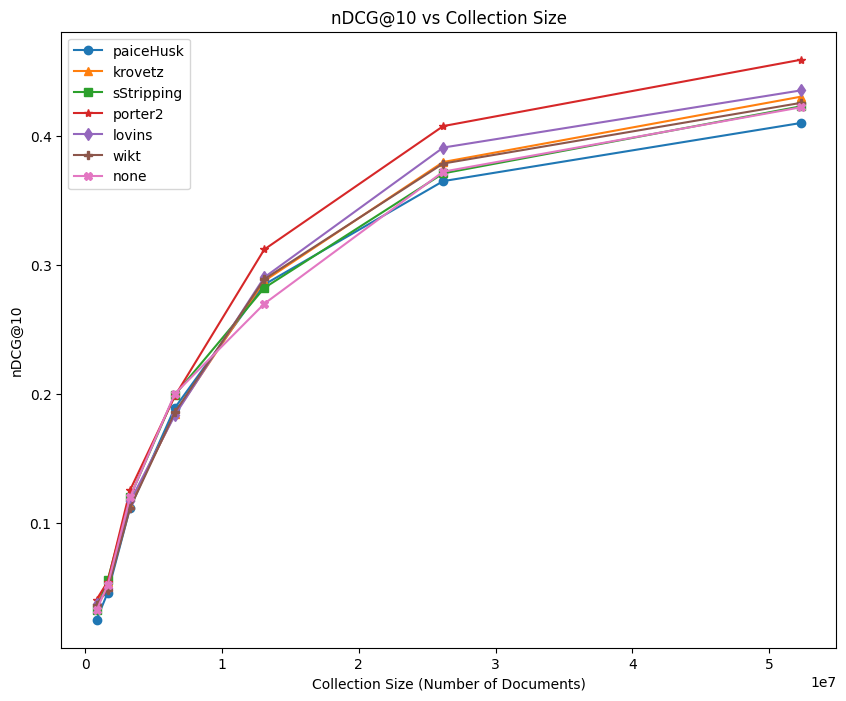

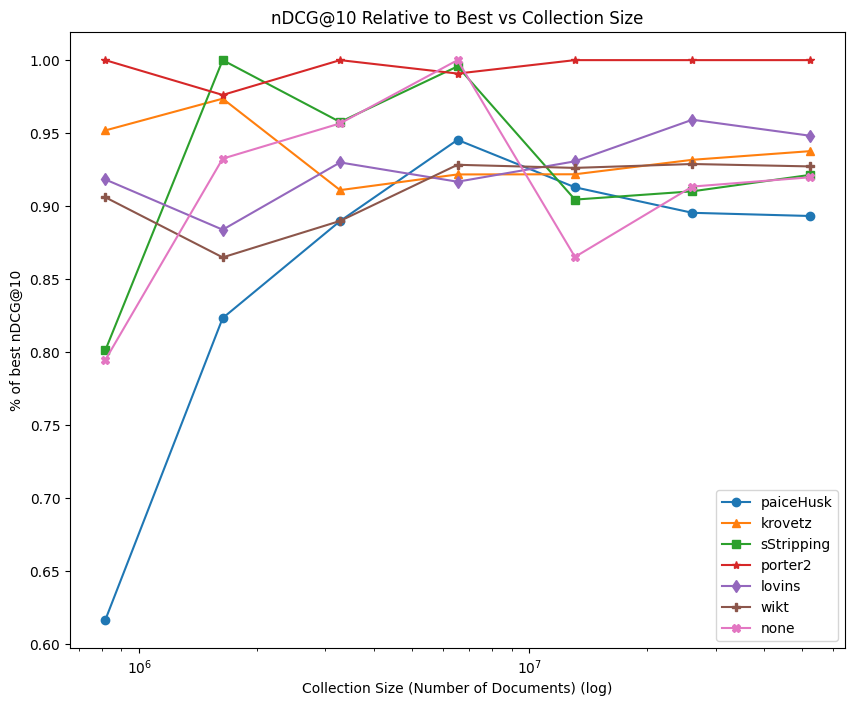

In [46]:
plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = nDCG_avg[nDCG_avg["stemmer"] == stemmer]
    plt.plot(stemmer_data["collectionSize"], stemmer_data["nDCG"], marker=next(markers), label=stemmer)

plt.title("nDCG@10 vs Collection Size")
plt.xlabel("Collection Size (Number of Documents)")
plt.ylabel("nDCG@10")
plt.legend()

# ----------------------------------------------------------------------

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = nDCG_avg[nDCG_avg["stemmer"] == stemmer]
    stemmer_values = np.array(stemmer_data["nDCG"])/best_nDCG
    plt.plot(stemmer_data["collectionSize"], stemmer_values, marker=next(markers), label=stemmer)
    plt.xscale("log")

plt.title("nDCG@10 Relative to Best vs Collection Size")
plt.xlabel("Collection Size (Number of Documents) (log)")
plt.ylabel("% of best nDCG@10")
plt.legend()

In [35]:
#t-test between the porter2 stemmer (one of the best performing) and no stemming
for length, size in zip(maxLengths, collection_sizes):
    p = list()
    n = list()
    target_data = nDCG[nDCG["maxLength"] == length]
    p = target_data[target_data["stemmer"] == "porter2"].loc[:,"nDCG"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"nDCG"].tolist()
    print(f"Length: {length} Size: {size} {stats.ttest_rel(p,n)}")


Length: 20 Size: 817857 TtestResult(statistic=1.6290518833541248, pvalue=0.10648012670233806, df=99)
Length: 55 Size: 1635715 TtestResult(statistic=0.5897563945177156, pvalue=0.556697594318676, df=99)
Length: 148 Size: 3271430 TtestResult(statistic=0.7949755412316691, pvalue=0.4285295011842304, df=99)
Length: 403 Size: 6542860 TtestResult(statistic=-0.14979077737799898, pvalue=0.881234426426355, df=99)
Length: 1097 Size: 13085721 TtestResult(statistic=2.93017995966416, pvalue=0.004206011852307164, df=99)
Length: 2981 Size: 26171443 TtestResult(statistic=2.4584171150936363, pvalue=0.015691628404684098, df=99)
Length: 2000000 Size: 52342886 TtestResult(statistic=2.153311305272994, pvalue=0.033722834541793444, df=99)


In [36]:
#t-test between the paiceHusk and no stemming
for length, size in zip(maxLengths, collection_sizes):
    s = list()
    n = list()
    target_data = nDCG[nDCG["maxLength"] == length]
    s = target_data[target_data["stemmer"] == "paiceHusk"].loc[:,"nDCG"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"nDCG"].tolist()
    print(f"Length: {length} Size: {size} {stats.ttest_rel(s,n)}")


Length: 20 Size: 817857 TtestResult(statistic=-1.0883190153951505, pvalue=0.2790966428329885, df=99)
Length: 55 Size: 1635715 TtestResult(statistic=-1.211517106961623, pvalue=0.2285811398965139, df=99)
Length: 148 Size: 3271430 TtestResult(statistic=-0.9197262775196634, pvalue=0.3599514009229515, df=99)
Length: 403 Size: 6542860 TtestResult(statistic=-0.9468427342110487, pvalue=0.34602431321103955, df=99)
Length: 1097 Size: 13085721 TtestResult(statistic=1.059205307929738, pvalue=0.2920837582528193, df=99)
Length: 2981 Size: 26171443 TtestResult(statistic=-0.4016717187268581, pvalue=0.6887914229656737, df=99)
Length: 2000000 Size: 52342886 TtestResult(statistic=-0.6119790202842499, pvalue=0.5419545913379433, df=99)


In [37]:
#t-test between the porter2 and paiceHusk
for length, size in zip(maxLengths, collection_sizes):
    s = list()
    n = list()
    target_data = nDCG[nDCG["maxLength"] == length]
    s = target_data[target_data["stemmer"] == "porter2"].loc[:,"nDCG"].tolist()
    n = target_data[target_data["stemmer"] == "paiceHusk"].loc[:,"nDCG"].tolist()
    print(f"Length: {length} Size: {size} {stats.ttest_rel(s,n)}")

Length: 20 Size: 817857 TtestResult(statistic=1.9479395828811872, pvalue=0.05425426997217839, df=99)
Length: 55 Size: 1635715 TtestResult(statistic=1.2736065376987986, pvalue=0.20578502823898673, df=99)
Length: 148 Size: 3271430 TtestResult(statistic=1.7176040113578868, pvalue=0.08899539033633716, df=99)
Length: 403 Size: 6542860 TtestResult(statistic=1.134314879973792, pvalue=0.2594016209307948, df=99)
Length: 1097 Size: 13085721 TtestResult(statistic=2.3032664954591997, pvalue=0.02335561174333578, df=99)
Length: 2981 Size: 26171443 TtestResult(statistic=2.348111716869002, pvalue=0.02085752705419418, df=99)
Length: 2000000 Size: 52342886 TtestResult(statistic=2.6301720068470575, pvalue=0.009897167595912582, df=99)


In [38]:
#t-test between the wikt and none
for length, size in zip(maxLengths, collection_sizes):
    s = list()
    n = list()
    target_data = nDCG[nDCG["maxLength"] == length]
    s = target_data[target_data["stemmer"] == "wikt"].loc[:,"nDCG"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"nDCG"].tolist()
    print(f"Length: {length} Size: {size} {stats.ttest_rel(s,n)}")

Length: 20 Size: 817857 TtestResult(statistic=1.0035034260686277, pvalue=0.31806450295023514, df=99)
Length: 55 Size: 1635715 TtestResult(statistic=-1.0044656916413073, pvalue=0.31760301092024484, df=99)
Length: 148 Size: 3271430 TtestResult(statistic=-1.0462202562840148, pvalue=0.29800705704613684, df=99)
Length: 403 Size: 6542860 TtestResult(statistic=-1.2031292643511948, pvalue=0.231795597795325, df=99)
Length: 1097 Size: 13085721 TtestResult(statistic=1.4047154111232039, pvalue=0.1632357865589663, df=99)
Length: 2981 Size: 26171443 TtestResult(statistic=0.4008555523252843, pvalue=0.6893902952029046, df=99)
Length: 2000000 Size: 52342886 TtestResult(statistic=0.20170380784047628, pvalue=0.8405621630592188, df=99)


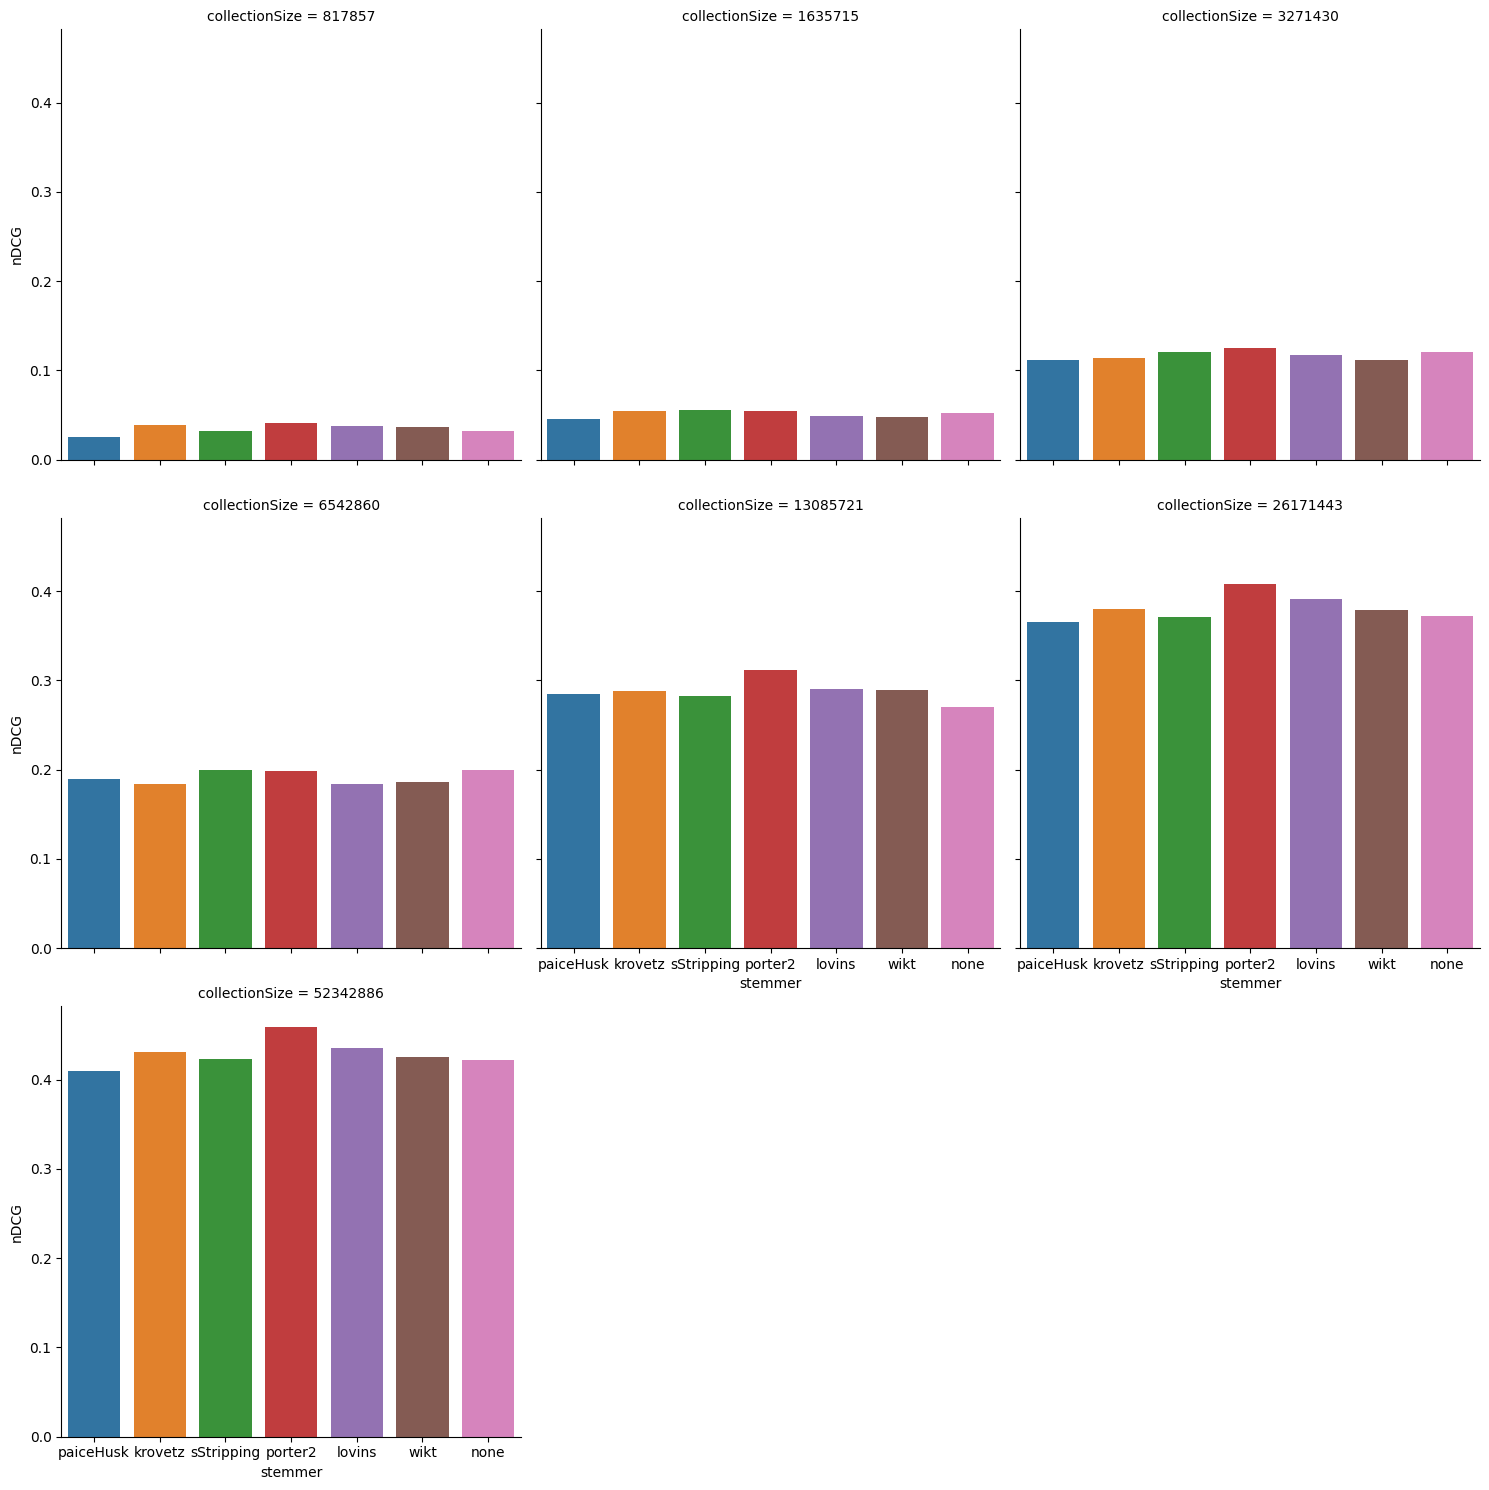

In [6]:
sns.catplot(data=nDCG_avg, kind="bar", x="stemmer", y="nDCG", col="collectionSize", col_wrap=3)
plt.show()